In [153]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import numpy as np
import matplotlib.pyplot as plt

In [155]:
with open('all.txt', 'r') as f:
    words = f.read().splitlines()

words = [w.strip().lower() for w in words if w.strip()]

seen = set()
unique_words = []
for word in words:
    if word not in seen:
        seen.add(word)
        unique_words.append(word)
words = unique_words

In [157]:
chars = sorted(list(set(''.join(words))))
vocab_size = len(chars) + 1  

stoi = {ch: i+1 for i, ch in enumerate(chars)}  
stoi['.'] = 0  

itos = {i: ch for ch, i in stoi.items()}  

print("Characters:", chars)
print("stoi:", stoi)
print("Vocabulary size:", vocab_size)

Characters: [' ', "'", '-', '?', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '¡', '§', '±', '»', '¿', 'ã', 'å', 'ï']
stoi: {' ': 1, "'": 2, '-': 3, '?': 4, 'a': 5, 'b': 6, 'c': 7, 'd': 8, 'e': 9, 'f': 10, 'g': 11, 'h': 12, 'i': 13, 'j': 14, 'k': 15, 'l': 16, 'm': 17, 'n': 18, 'o': 19, 'p': 20, 'q': 21, 'r': 22, 's': 23, 't': 24, 'u': 25, 'v': 26, 'w': 27, 'x': 28, 'y': 29, 'z': 30, '¡': 31, '§': 32, '±': 33, '»': 34, '¿': 35, 'ã': 36, 'å': 37, 'ï': 38, '.': 0}
Vocabulary size: 39


In [159]:
def encode(s):
    return [stoi[c] for c in s]

def decode(indices):
    return ''.join([itos[i] for i in indices])

In [161]:
print(encode("emma."))    
print(decode([5, 7, 7, 1, 0]))

[9, 17, 17, 5, 0]
acc .


In [163]:
context_size = 3  

X, Y = [], []

for word in words:
    context = [0] * context_size  
    for ch in word + '.':  
        ix = stoi[ch]
        X.append(context)    
        Y.append(ix)         
        context = context[1:] + [ix]  

X = torch.tensor(X)
Y = torch.tensor(Y)

print("Input shape:", X.shape)
print("Target shape:", Y.shape)
print("Example X[0]:", X[0].tolist(), "->", "Target Y[0]:", Y[0].item(), "(", decode([Y[0].item()]), ")")

Input shape: torch.Size([145835, 3])
Target shape: torch.Size([145835])
Example X[0]: [0, 0, 0] -> Target Y[0]: 38 ( ï )


In [164]:
class NameMLP(nn.Module):
    def __init__(self, vocab_size, context_size, embedding_dim=10, hidden_dim=100):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)  
        self.fc1 = nn.Linear(context_size * embedding_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x):
        emb = self.embedding(x)             
        emb = emb.view(emb.shape[0], -1)    
        hidden = F.relu(self.fc1(emb))      
        logits = self.fc2(hidden)           
        return logits

In [165]:
model = NameMLP(vocab_size=vocab_size, context_size=context_size)

In [166]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

epochs = 200
losses = []

for epoch in range(epochs):
    logits = model(X)
    loss = loss_fn(logits, Y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

    if epoch % 20 == 0 or epoch == epochs - 1:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

Epoch 1/200, Loss: 3.6865
Epoch 21/200, Loss: 2.5313
Epoch 41/200, Loss: 2.3975
Epoch 61/200, Loss: 2.3402
Epoch 81/200, Loss: 2.3083
Epoch 101/200, Loss: 2.2869
Epoch 121/200, Loss: 2.2712
Epoch 141/200, Loss: 2.2586
Epoch 161/200, Loss: 2.2487
Epoch 181/200, Loss: 2.2397
Epoch 200/200, Loss: 2.2329


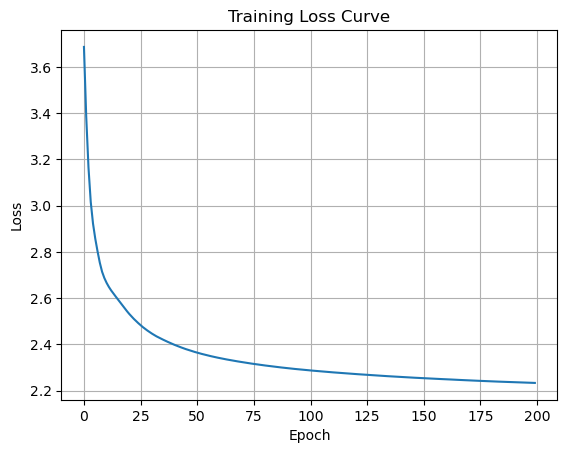

In [167]:
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.grid(True)
plt.show()

In [168]:
def sample(model, max_length=20, num_names=10):
    model.eval()  
    
    for _ in range(num_names):
        context = [0] * context_size  
        name = []

        for _ in range(max_length):
            x = torch.tensor([context])
            logits = model(x)
            probs = F.softmax(logits, dim=1)
            ix = torch.multinomial(probs, num_samples=1).item()  

            if ix == 0:  
                break

            name.append(itos[ix])
            context = context[1:] + [ix]  

        print(''.join(name))

    model.train()  

In [169]:
sample(model, num_names=10)

qian
erfingweidus
shuema
magatio
sutanria
wil
mitauleonasharsise
xiao
yuder
crisalin


In [170]:
torch.save(model.state_dict(), 'makemore_mlp.pt')
print("Model saved to makemore_mlp.pt")

Model saved to makemore_mlp.pt


In [171]:
def sample_advanced(model, max_length=20, num_names=10, temperature=1.0, top_k=None):
    model.eval()

    for _ in range(num_names):
        context = [0] * context_size
        name = []

        for _ in range(max_length):
            x = torch.tensor([context])
            logits = model(x)

            logits = logits / temperature

            if top_k is not None:
                topk_vals, topk_idx = torch.topk(logits, k=top_k)
                logits_filtered = torch.full_like(logits, float('-inf'))
                logits_filtered.scatter_(1, topk_idx, topk_vals)
                probs = F.softmax(logits_filtered, dim=1)
            else:
                probs = F.softmax(logits, dim=1)

            ix = torch.multinomial(probs, num_samples=1).item()

            if ix == 0:
                break

            name.append(itos[ix])
            context = context[1:] + [ix]

        print(''.join(name))

    model.train()

In [173]:
print("Temperature = 1.5, Top-k = 5")
sample_advanced(model, num_names=10, temperature=1.5, top_k=5)

print("\n Temperature = 0.7, Top-k = 10")
sample_advanced(model, num_names=10, temperature=0.7, top_k=10)

Temperature = 1.5, Top-k = 5
emmara
lucion
alesar
mounasima
lossandruchrine
solongamiangaldinete
ariana
miroustas
anta
essam

 Temperature = 0.7, Top-k = 10
marcene
caro
sia
jameline
bachaida
moum
abda
mehta
larickit
dadilianne


In [176]:
import random

random.seed(42)
num_data = len(X)  
indices = list(range(num_data))
random.shuffle(indices)

n_train = int(0.8 * num_data)
n_dev = int(0.1 * num_data)

train_idx = indices[:n_train]
dev_idx = indices[n_train:n_train + n_dev]
test_idx = indices[n_train + n_dev:]

X_train, Y_train = X[train_idx], Y[train_idx]
X_dev, Y_dev = X[dev_idx], Y[dev_idx]
X_test, Y_test = X[test_idx], Y[test_idx]

print(f"Train: {len(X_train)}, Dev: {len(X_dev)}, Test: {len(X_test)}")

Train: 116668, Dev: 14583, Test: 14584


In [177]:
def get_batch(split, batch_size=32):
    if split == 'train':
        X_data, Y_data = X_train, Y_train
    elif split == 'dev':
        X_data, Y_data = X_dev, Y_dev
    else:
        X_data, Y_data = X_test, Y_test

    idx = torch.randint(0, len(X_data), (batch_size,))
    xb = X_data[idx]
    yb = Y_data[idx]
    return xb, yb

In [178]:
xb, yb = get_batch('train', batch_size=32)
print(xb.shape, yb.shape)

torch.Size([32, 3]) torch.Size([32])


In [179]:
learning_rates = [1e-4, 1e-3, 1e-2, 1e-1]
results = {}

context_size = 3  

for lr in learning_rates:
    model = NameMLP(vocab_size, context_size)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_log = []

    for step in range(1000):
        xb, yb = get_batch('train', batch_size=32)
        logits = model(xb)
        loss = F.cross_entropy(logits, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_log.append(loss.item())

    results[lr] = sum(loss_log[-100:]) / 100

for lr, final_loss in results.items():
    print(f"LR: {lr} → Avg Final Loss: {final_loss:.4f}")


LR: 0.0001 → Avg Final Loss: 2.7998
LR: 0.001 → Avg Final Loss: 2.4773
LR: 0.01 → Avg Final Loss: 2.4487
LR: 0.1 → Avg Final Loss: 2.8902


In [180]:
model = NameMLP(vocab_size, context_size)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [181]:
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.5)

In [182]:
losses_train = []
losses_dev = []

for step in range(5000):
    xb, yb = get_batch('train', batch_size=32)
    logits = model(xb)
    loss = F.cross_entropy(logits, yb)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()

    if step % 100 == 0:
        with torch.no_grad():
            xdev, ydev = get_batch('dev', batch_size=256)
            dev_loss = F.cross_entropy(model(xdev), ydev)
        print(f"Step {step}: Train Loss = {loss.item():.4f}, Dev Loss = {dev_loss.item():.4f}")
        losses_train.append(loss.item())
        losses_dev.append(dev_loss.item())

Step 0: Train Loss = 3.7155, Dev Loss = 3.5160
Step 100: Train Loss = 2.2826, Dev Loss = 2.5419
Step 200: Train Loss = 2.8441, Dev Loss = 2.4804
Step 300: Train Loss = 2.6887, Dev Loss = 2.5111
Step 400: Train Loss = 2.6036, Dev Loss = 2.5480
Step 500: Train Loss = 2.3671, Dev Loss = 2.5156
Step 600: Train Loss = 2.2953, Dev Loss = 2.3484
Step 700: Train Loss = 2.2328, Dev Loss = 2.3996
Step 800: Train Loss = 2.8764, Dev Loss = 2.4477
Step 900: Train Loss = 2.7075, Dev Loss = 2.3454
Step 1000: Train Loss = 2.2169, Dev Loss = 2.4710
Step 1100: Train Loss = 2.3107, Dev Loss = 2.3780
Step 1200: Train Loss = 2.3926, Dev Loss = 2.3050
Step 1300: Train Loss = 2.2511, Dev Loss = 2.3498
Step 1400: Train Loss = 2.5462, Dev Loss = 2.3355
Step 1500: Train Loss = 2.5240, Dev Loss = 2.4127
Step 1600: Train Loss = 2.5774, Dev Loss = 2.3768
Step 1700: Train Loss = 2.3853, Dev Loss = 2.3339
Step 1800: Train Loss = 2.0662, Dev Loss = 2.4571
Step 1900: Train Loss = 2.5646, Dev Loss = 2.4095
Step 2000: T

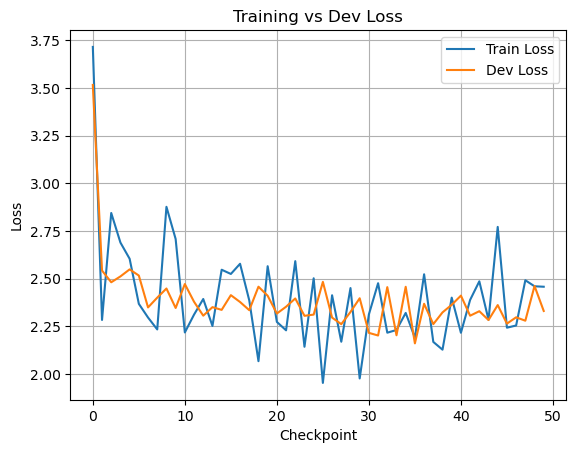

In [183]:
import matplotlib.pyplot as plt

plt.plot(losses_train, label='Train Loss')
plt.plot(losses_dev, label='Dev Loss')
plt.xlabel("Checkpoint")
plt.ylabel("Loss")
plt.title("Training vs Dev Loss")
plt.legend()
plt.grid(True)
plt.show()

In [184]:
class NameMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, 10)  
        self.hidden = nn.Linear(10 * block_size, 200)
        self.bn1 = nn.BatchNorm1d(200)                
        self.dropout = nn.Dropout(0.2)                 
        self.out = nn.Linear(200, vocab_size)

        # Kaiming initialization
        nn.init.kaiming_normal_(self.hidden.weight, nonlinearity='relu')
        nn.init.zeros_(self.hidden.bias)
        nn.init.zeros_(self.out.bias)
        nn.init.kaiming_normal_(self.out.weight, nonlinearity='linear')

    def forward(self, x):
        emb = self.embedding(x)              
        emb_flat = emb.view(emb.shape[0], -1)  
        h = self.hidden(emb_flat)
        h = self.bn1(h)                      
        h = F.relu(h)
        h = self.dropout(h)                  
        logits = self.out(h)
        return logits

In [185]:
for name, param in model.named_parameters():
    if param.grad is not None and "weight" in name:
        grad_norm = param.grad.norm().item()
        print(f"{name} grad norm: {grad_norm:.4f}")

embedding.weight grad norm: 0.1911
fc1.weight grad norm: 0.6249
fc2.weight grad norm: 0.7451


In [186]:
block_size = 3
vocab_size = len(stoi)
model = NameMLP(vocab_size, block_size)

TypeError: NameMLP.__init__() takes 1 positional argument but 3 were given

In [ ]:
model.eval()
xb, yb = get_batch('dev', batch_size=1)

with torch.no_grad():
    emb = model.embedding(xb)
    flat = emb.view(1, -1)
    h = model.hidden(flat)

    import matplotlib.pyplot as plt
    plt.hist(h.cpu().numpy().flatten(), bins=50)
    plt.title("Hidden Layer Activations")
    plt.grid(True)
    plt.show()

In [ ]:
plt.plot(losses_train, label='Train Loss')
plt.plot(losses_dev, label='Dev Loss')
plt.xlabel("Checkpoint")
plt.ylabel("Loss")
plt.title("Training vs Dev Loss")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import os
import os
import torch

def save_checkpoint(model, optimizer, epoch, filepath="checkpoints/model_checkpoint.pth"):
    filepath = os.path.normpath(filepath)

    directory = os.path.dirname(filepath)
    if directory and not os.path.exists(directory):
        os.makedirs(directory)

    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }
    torch.save(checkpoint, filepath)
    print(f" Checkpoint saved at: {filepath}")

In [ ]:
def load_checkpoint(model, optimizer, filepath="checkpoints/model_checkpoint.pth"):
    filepath = os.path.normpath(filepath)

    if not os.path.exists(filepath):
        print(f" No checkpoint found at: {filepath}")
        return model, optimizer, 0
    
    checkpoint = torch.load(filepath)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    print(f" Checkpoint loaded from: {filepath} (epoch {epoch})")
    return model, optimizer, epoch

In [ ]:
import torch.nn.functional as F

def top_p_sampling(logits, p=0.9):
    sorted_logits, sorted_indices = torch.sort(logits, descending=True)
    sorted_probs = F.softmax(sorted_logits, dim=-1)
    cumulative_probs = torch.cumsum(sorted_probs, dim=-1)

    sorted_indices_to_remove = cumulative_probs > p
    sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
    sorted_indices_to_remove[..., 0] = False

    filtered_logits = sorted_logits.masked_fill(sorted_indices_to_remove, float('-inf'))

    probs = F.softmax(filtered_logits, dim=-1)
    next_token = torch.multinomial(probs, num_samples=1)
    next_token = sorted_indices[next_token]
    return next_token.item()

In [ ]:
model = NameMLP(vocab_size, block_size)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model, optimizer, start_epoch = load_checkpoint(model, optimizer)

num_epochs = 10
for epoch in range(start_epoch, num_epochs):
    save_checkpoint(model, optimizer, epoch)

In [ ]:
def sample_next_token(logits, temperature=1.0, top_k=None, top_p=None):
    logits = logits / temperature

    if top_k is not None:
        top_k = min(top_k, logits.size(-1))
        values, indices = torch.topk(logits, top_k)
        probs = torch.zeros_like(logits).scatter_(-1, indices, F.softmax(values, dim=-1))
    else:
        probs = F.softmax(logits, dim=-1)

    if top_p is not None:
        sorted_probs, sorted_indices = torch.sort(probs, descending=True)
        cumulative_probs = torch.cumsum(sorted_probs, dim=-1)
        sorted_indices_to_remove = cumulative_probs > top_p
        sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
        sorted_indices_to_remove[..., 0] = False
        sorted_probs = sorted_probs.masked_fill(sorted_indices_to_remove, 0.0)
        probs = torch.zeros_like(probs).scatter_(-1, sorted_indices, sorted_probs)

    probs = probs / probs.sum()  # Renormalize
    next_token = torch.multinomial(probs, 1)
    return next_token.item()

In [ ]:
def generate_name(model, start_context, max_length=20, temperature=1.0, top_k=10, top_p=0.9):
    model.eval()
    generated = start_context[:]  

    for _ in range(max_length):
        x = torch.tensor([generated[-block_size:]], dtype=torch.long)
        logits = model(x)
        logits = logits[0, -1, :] 

        next_id = sample_next_token(logits, temperature, top_k, top_p)
        generated.append(next_id)

        if next_id == token_to_id['.']:  
            break

    return ''.join(id_to_token[i] for i in generated)

In [193]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt


vocab = sorted(list(set(open('all.txt').read()) | set('.')))
vocab_size = len(vocab)
stoi = {ch: i for i, ch in enumerate(vocab)}
itos = {i: ch for ch, i in stoi.items()}
block_size = 8

def encode(s): return [stoi[c] for c in s]
def decode(l): return ''.join([itos[i] for i in l])


data = open('all.txt').read().splitlines()
x, y = [], []
for name in data:
    context = [0] * block_size
    for ch in name + '.':
        ix = stoi[ch]
        x.append(context[:])
        y.append(ix)
        context = context[1:] + [ix]

x = torch.tensor(x)
y = torch.tensor(y)

class NameCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, 10)
        self.conv1 = nn.Conv1d(10, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(64 * block_size, vocab_size)

    def forward(self, x):
        x = self.embedding(x)        
        x = x.permute(0, 2, 1)       
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.shape[0], -1)
        x = self.dropout(x)
        return self.fc(x)

model = NameCNN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
losses = []

for step in range(5000):
    ix = torch.randint(0, x.shape[0], (32,))
    xb, yb = x[ix], y[ix]

    logits = model(xb)
    loss = F.cross_entropy(logits, yb)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if step % 500 == 0:
        print(f"Step {step}: loss = {loss.item():.4f}")
    losses.append(loss.item())

def generate_cnn(model, max_len=20):
    model.eval()
    context = [0] * block_size
    result = []
    while True:
        x_in = torch.tensor([context])
        logits = model(x_in)
        probs = F.softmax(logits, dim=-1)
        ix = torch.multinomial(probs, num_samples=1).item()
        context = context[1:] + [ix]
        if ix == stoi['.'] or len(result) >= max_len:
            break
        result.append(ix)
    return decode(result)

print("\nGenerated Names (CNN):")
for _ in range(5):
    print(generate_cnn(model))

class SelfAttentionHead(nn.Module):
    def __init__(self, embed_dim):
        super().__init__()
        self.key = nn.Linear(embed_dim, embed_dim, bias=False)
        self.query = nn.Linear(embed_dim, embed_dim, bias=False)
        self.value = nn.Linear(embed_dim, embed_dim, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

    def forward(self, x):
        B, T, C = x.shape
        k = self.key(x)
        q = self.query(x)
        wei = q @ k.transpose(-2, -1) / (C ** 0.5)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        wei = F.softmax(wei, dim=-1)
        v = self.value(x)
        return wei @ v

class TinyTransformer(nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, 32)
        self.attn = SelfAttentionHead(32)
        self.ln1 = nn.LayerNorm(32)
        self.fc = nn.Linear(32 * block_size, vocab_size)

    def forward(self, x):
        x = self.embedding(x)  # (B, T, C)
        x = self.attn(x)
        x = self.ln1(x)
        x = x.view(x.shape[0], -1)
        return self.fc(x)

model_t = TinyTransformer()
optimizer = torch.optim.Adam(model_t.parameters(), lr=0.001)

for step in range(5000):
    ix = torch.randint(0, x.shape[0], (32,))
    xb, yb = x[ix], y[ix]

    logits = model_t(xb)
    loss = F.cross_entropy(logits, yb)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if step % 500 == 0:
        print(f"[Transformer] Step {step}: loss = {loss.item():.4f}")

def generate_transformer(model, max_len=20):
    model.eval()
    context = [0] * block_size
    result = []
    while True:
        x_in = torch.tensor([context])
        logits = model(x_in)
        probs = F.softmax(logits, dim=-1)
        ix = torch.multinomial(probs, num_samples=1).item()
        context = context[1:] + [ix]
        if ix == stoi['.'] or len(result) >= max_len:
            break
        result.append(ix)
    return decode(result)

print("\nGenerated Names (Transformer):")
for _ in range(5):
    print(generate_transformer(model_t))

Step 0: loss = 4.1726
Step 500: loss = 2.2635
Step 1000: loss = 2.6670
Step 1500: loss = 2.4910
Step 2000: loss = 2.1287
Step 2500: loss = 2.2085
Step 3000: loss = 2.0361
Step 3500: loss = 2.5942
Step 4000: loss = 2.3380
Step 4500: loss = 2.2891

Generated Names (CNN):
Kolia
Arnellya
Tladina
MaÃanis
Famiga
[Transformer] Step 0: loss = 4.3730
[Transformer] Step 500: loss = 2.5357
[Transformer] Step 1000: loss = 2.6699
[Transformer] Step 1500: loss = 2.1725
[Transformer] Step 2000: loss = 2.2268
[Transformer] Step 2500: loss = 2.5539
[Transformer] Step 3000: loss = 2.5130
[Transformer] Step 3500: loss = 2.3176
[Transformer] Step 4000: loss = 1.8783
[Transformer] Step 4500: loss = 2.1822

Generated Names (Transformer):
Wolde
Sulvias
Irebi
Mpihano
Blavak
